In [5]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [ ]:
# config取得
base_dir = Path.cwd().parent.parent
config_path = base_dir / "config"
sys.path.append(str(config_path))

from config import (
    RANDOM_SEED
)

In [6]:
# csvデータの取得
base_dir = Path(os.getcwd())
common_dir = base_dir.parent.parent / "assets" / "csv_data" 
input_path = common_dir / "主要被害公園エリア_乱数値結合済み.csv"
df = pd.read_csv(input_path)
display(df)

,park_name,経度,緯度,grid_id,green_ratio,yellow_brown_ratio,color_std,hue_mean,ndvi_avg,ndvi_std,ndvi_min,ndvi_max,leaf_temp_mean,label
0,桜ヶ丘公園,139.4567,35.6390,35.6390_139.4567,0.459612,0.785722,0.192519,59.384835,0.304189,0.248984,0.238098,0.880689,33.298713,E
1,桜ヶ丘公園,139.4567,35.6387,35.6387_139.4567,0.479500,0.084902,0.086805,60.375179,0.630559,0.364002,0.609107,0.797351,27.397116,E
2,桜ヶ丘公園,139.4571,35.6403,35.6403_139.4571,0.485491,0.753272,0.220034,63.004569,0.591053,0.000000,0.097239,0.907153,31.642257,D
3,桜ヶ丘公園,139.4571,35.6400,35.6400_139.4571,0.400513,0.568641,0.125061,83.833420,0.595624,0.000000,0.706339,0.779235,30.533073,D
4,桜ヶ丘公園,139.4571,35.6398,35.6398_139.4571,0.585060,0.250759,0.072748,97.396637,0.753502,0.156121,0.539966,1.000000,33.048419,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5941,八王子霊園,139.2762,35.6599,35.6599_139.2762,0.348541,0.377199,0.196278,91.826972,0.618802,0.087845,0.192817,0.760627,33.987499,E
5942,八王子霊園,139.2764,35.6607,35.6607_139.2764,0.690633,0.110610,0.098884,88.994973,0.858774,0.150090,0.947386,0.826191,29.898037,H
5943,八王子霊園,139.2764,35.6601,35.6601_139.2764,0.204938,0.827446,0.190168,73.427794,0.208723,0.235991,0.323419,0.568565,42.396146,D
5944,八王子霊園,139.2764,35.6599,35.6599_139.2764,0.641633,0.114654,0.203125,97.612755,0.907921,0.000000,0.671873,1.000000,31.278356,H


c:\Users\kyous\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogisticRegression (OHE in Pipeline) ===
Accuracy: 0.887  |  Macro-F1: 0.887
              precision    recall  f1-score   support

           D      0.889     0.900     0.894       418
           E      0.893     0.836     0.863       677
           H      0.880     0.929     0.904       689

    accuracy                          0.887      1784
   macro avg      0.887     0.888     0.887      1784
weighted avg      0.887     0.887     0.886      1784

Confusion Matrix (rows=true, cols=pred):
 [[640  44   5]
 [ 69 566  42]
 [ 18  24 376]]

CV Macro-F1 (LR): mean=0.888 ± 0.006


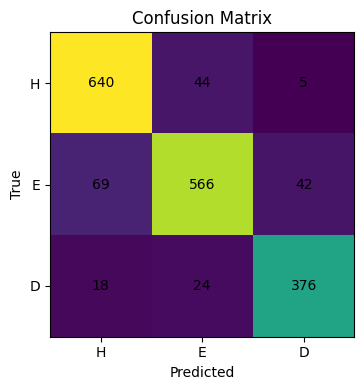

In [8]:
# --- 特徴量定義（数値＋カテゴリ）---
num_cols = [
    "green_ratio",
    "yellow_brown_ratio",
    "color_std","hue_mean",
    "ndvi_avg",
    "ndvi_std",
    "ndvi_min",
    "ndvi_max",
    "leaf_temp_mean"
]

# 不要列の除去
df = df.drop(columns=[c for c in ["grid_id"] if c in df.columns], errors="ignore")

# 必要列チェック
cat_cols = ["park_name"]
missing = [c for c in (num_cols + cat_cols + ["label"]) if c not in df.columns]
if missing:
    raise ValueError(f"必要な列が見つかりません: {missing}")

# 入出力
X = df[num_cols + cat_cols]
y = df["label"].to_numpy()

# 分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_SEED
)

# --- 前処理 + ロジスティック回帰（正則化少し強め）---
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="drop"
)

pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        multi_class="ovr",
        max_iter=1000,
        random_state=RANDOM_SEED,
        C=0.5,
        penalty="l2",
        solver="lbfgs"
    ))
])

# --- 学習 ---
pipe_lr.fit(X_train, y_train)

# --- 評価関数 ---
def eval_model(name, model):
    y_pred = model.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}  |  Macro-F1: {f1m:.3f}")
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred, labels=["H","E","D"])
    print("Confusion Matrix (rows=true, cols=pred):\n", cm)
    return y_pred, cm

y_pred_lr, cm_lr = eval_model("LogisticRegression (OHE in Pipeline)", pipe_lr)

# --- 交差検証---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
cv_lr = cross_val_score(pipe_lr, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
print(f"\nCV Macro-F1 (LR): mean={cv_lr.mean():.3f} ± {cv_lr.std():.3f}")

# --- 混同行列の可視化 ---
def plot_cm(cm, labels=("H","E","D"), title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm)
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels)
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_cm(cm_lr, title="Confusion Matrix")